In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Function
import numpy as np
import torchvision
from BNN import *
from spikingjelly.activation_based import functional

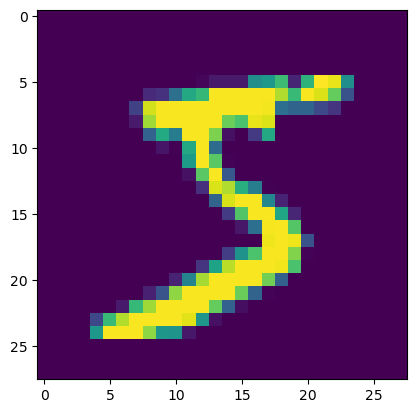

tensor([[[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
           18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,

In [9]:
#加载MNIST数据集
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='/home/curry/code', train=True, transform=transform, download=True)

#加载MNIST数据集的第一张图片
image, label = train_dataset[0]
#将图片用matplotlib画出来
import matplotlib.pyplot as plt
plt.imshow(image.squeeze().numpy())
plt.show()
#讲image转化为int8类型
image = image * 255
print(image.int())

#用一个权重全为1的卷积核对图片进行卷积
conv = nn.Conv2d(1, 1, 5, 1, 0, bias=False)
conv.weight.data.fill_(-1)
output = conv(image)
print(output.shape)
print(output.int())
pool = nn.MaxPool2d(2, 2)
output2 = pool(output)
print(output2.shape)
print(output2.int())
image = image.int()
#按行将image转化为txt文件
with open('/home/curry/code/curry_code_summay/rtl_works/BNN_on_fpga/test_image_txt.txt', 'w') as f:
    for i in range(28):
        for j in range(28):
            f.write(format(image[0, i, j].item(), '08b') + '\n')
output_int = output.int()
#按行将output转化为32位有符号整数的txt文件
with open('/home/curry/code/curry_code_summay/rtl_works/BNN_on_fpga/test_output_txt.txt', 'w') as f:
    for i in range(24):
        for j in range(24):
            value = output_int[0, i, j].item()
            if value < 0:
                value = (1 << 32) + value  # 将负数转换为32位有符号整数的二进制表示
            f.write(format(value, '032b') + '\n')

In [2]:
class LeNet(nn.Module):
    def __init__(self, num_classes=10, T=4):
        super().__init__()
        self.T = T
        self.conv1 = BinaryConv2d(1, 6, kernel_size=5, stride=1, padding=0, bias=False)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu1 = nn.ReLU()
        self.conv2 = BinaryConv2d(6, 12, kernel_size=5, stride=1, padding=0, bias=False)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu2 = nn.ReLU()
        self.fc1 = BinaryLinear(12*4*4, 120, bias=False)
        self.relu3 = nn.ReLU()
        self.fc2 = BinaryLinear(120, 84, bias=False)
        self.relu4 = nn.ReLU()
        self.fc3 = BinaryLinear(84, num_classes, bias=False)
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.relu2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.relu3(x)
        x = self.fc3(x)
        return x

In [3]:
net = LeNet()
functional.set_step_mode(net, 'm')
print(net)

LeNet(
  (conv1): BinaryConv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu1): ReLU()
  (conv2): BinaryConv2d(6, 12, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu2): ReLU()
  (fc1): BinaryLinear(in_features=192, out_features=120, bias=False)
  (relu3): ReLU()
  (fc2): BinaryLinear(in_features=120, out_features=84, bias=False)
  (relu4): ReLU()
  (fc3): BinaryLinear(in_features=84, out_features=10, bias=False)
)


In [4]:
x = torch.randn(128, 1, 28, 28)
y = net(x)
print(y.size())

torch.Size([128, 10])


In [5]:
dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

In [6]:
from tqdm import tqdm
np.int = int
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
EPOCH = 10
device = torch.device('cuda:0')
net.to(device)
for epoch in range(EPOCH):
    net.train()
    for i ,data in enumerate(dataloader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        functional.reset_net(net)
        if i % 100 == 0:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, loss.item()))
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i,data in enumerate(testloader):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
torch.save(net.state_dict(), 'weight/lenet.pth')

[1,     1] loss: 2.302
[1,   101] loss: 0.762
[1,   201] loss: 0.435
[1,   301] loss: 0.275
[1,   401] loss: 0.306
Accuracy of the network on the 10000 test images: 93 %
[2,     1] loss: 0.232
[2,   101] loss: 0.171
[2,   201] loss: 0.222
[2,   301] loss: 0.184
[2,   401] loss: 0.202
Accuracy of the network on the 10000 test images: 96 %
[3,     1] loss: 0.203
[3,   101] loss: 0.139
[3,   201] loss: 0.112
[3,   301] loss: 0.147
[3,   401] loss: 0.298
Accuracy of the network on the 10000 test images: 96 %
[4,     1] loss: 0.269
[4,   101] loss: 0.160
[4,   201] loss: 0.074
[4,   301] loss: 0.127
[4,   401] loss: 0.116
Accuracy of the network on the 10000 test images: 97 %
[5,     1] loss: 0.077
[5,   101] loss: 0.071
[5,   201] loss: 0.139
[5,   301] loss: 0.060
[5,   401] loss: 0.038
Accuracy of the network on the 10000 test images: 97 %
[6,     1] loss: 0.077
[6,   101] loss: 0.065
[6,   201] loss: 0.130
[6,   301] loss: 0.147
[6,   401] loss: 0.110
Accuracy of the network on the 1000

In [2]:
class scale_Bconvd(BinaryConv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=False):
        super(scale_Bconvd, self).__init__(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias)
    def forward(self, x):
        w = self.weight
        bw = BinaryWeight.apply(w)
        scaling_factor = torch.mean(torch.mean(torch.mean(torch.mean(abs(w),dim=3,keepdim=True),dim=2,keepdim=True),dim=1,keepdim=True),dim=0,keepdim=True)
        scaling_factor = scaling_factor.detach()
        print(scaling_factor)
        # bw = scaling_factor * BinaryWeight.apply(w)
    
        return F.conv2d(x, bw, self.bias, self.stride,
                    self.padding, self.dilation, self.groups)
class scale_Blinear(BinaryLinear):
    def __init__(self, in_features, out_features, bias=False):
        super(scale_Blinear, self).__init__(in_features, out_features, bias)
        
    def forward(self, x):

        w = self.weight
        bw = BinaryWeight.apply(w)
        # print(w.shape)
        scaling_factor = torch.mean(torch.mean(abs(w),dim=1,keepdim=True),dim=0,keepdim=True)
        scaling_factor = scaling_factor.detach()
        print(scaling_factor)
        # bw = scaling_factor * BinaryWeight.apply(w)
        
        return F.linear(x, bw, self.bias)

In [3]:
class scale_leNet(nn.Module):
    def __init__(self, num_classes=10, T=4):
        super().__init__()
        self.T = T
        self.conv1 = scale_Bconvd(1, 6, kernel_size=5, stride=1, padding=0, bias=False)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu1 = nn.ReLU()
        self.conv2 = scale_Bconvd(6, 12, kernel_size=5, stride=1, padding=0, bias=False)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu2 = nn.ReLU()
        self.fc1 = scale_Blinear(12*4*4, 120, bias=False)
        self.relu3 = nn.ReLU()
        self.fc2 = scale_Blinear(120, 84, bias=False)
        self.relu4 = nn.ReLU()
        self.fc3 = scale_Blinear(84, num_classes, bias=False)
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.relu2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.relu4(x)
        x = self.fc3(x)
        return x

In [4]:
net = scale_leNet()
functional.set_step_mode(net, 'm')
print(net)
#加载权重
net.load_state_dict(torch.load('weight/lenet.pth'))
net.to(device)
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for i,data in enumerate(testloader):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

scale_leNet(
  (conv1): scale_Bconvd(1, 6, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu1): ReLU()
  (conv2): scale_Bconvd(6, 12, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu2): ReLU()
  (fc1): scale_Blinear(in_features=192, out_features=120, bias=False)
  (relu3): ReLU()
  (fc2): scale_Blinear(in_features=120, out_features=84, bias=False)
  (relu4): ReLU()
  (fc3): scale_Blinear(in_features=84, out_features=10, bias=False)
)


/tmp/ipykernel_18392/3637794216.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('weight/lenet.pth'))


NameError: name 'device' is not defined

ModuleNotFoundError: No module named 'torchvision'